# Autoregressive Models

## Imports

In [1]:
import sys
sys.path.insert(0, '../src/')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from datetime import date
import geopandas as gpd
from IPython.display import display, HTML
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.ar_model import AR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from utils import load_pkl, generate_times
import seaborn as sns; sns.set()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from metrics import *

from preprocessing import normalize

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Loading Data

### Contour Iris

In [239]:
contour_iris = gpd.read_file(
    '../datasets/iris/iris.shp')

convert_to_int = ['dep', 'insee_com', 'iris', 'code_iris']
for col in convert_to_int:
    contour_iris[col] = contour_iris[col].astype(int)

contour_iris = contour_iris[['code_iris', 'geometry', 'dep']]
contour_iris.head();

### Stations and Dates

In [240]:
station_data = pd.read_csv("../datasets/station_to_iris.csv")
station_data.describe();

In [241]:
stations_mode = load_pkl("../datasets/stations_mode.pkl")
subway_stations = [k for k, v in stations_mode.items() if v == 3]
print("Number of Subway stations: {}".format(len(subway_stations)))

Number of Subway stations: 303


Subways stations with less than $80000$ validations per $3$ month. Note that this is before we normalize the data. In the article, they removed $3$ subways stations, assuming that it was closed for renovation work. We printed below the $4$ stations with smaller number of validations.

In [242]:
station_data[(station_data['id'].isin(subway_stations)) & (station_data['validations_count'] < 80000)];

In [243]:
dates = pd.date_range(start="2015-10-01", end="2015-12-31").date

### Discretized Matrix

In [244]:
matrix_6h = np.load("../datasets/6h_matrix.npy")
matrix_2h = np.load("../datasets/2h_matrix.npy")
matrix_15m = np.load("../datasets/15m_matrix.npy")

## Data Analysis and Preprocessing

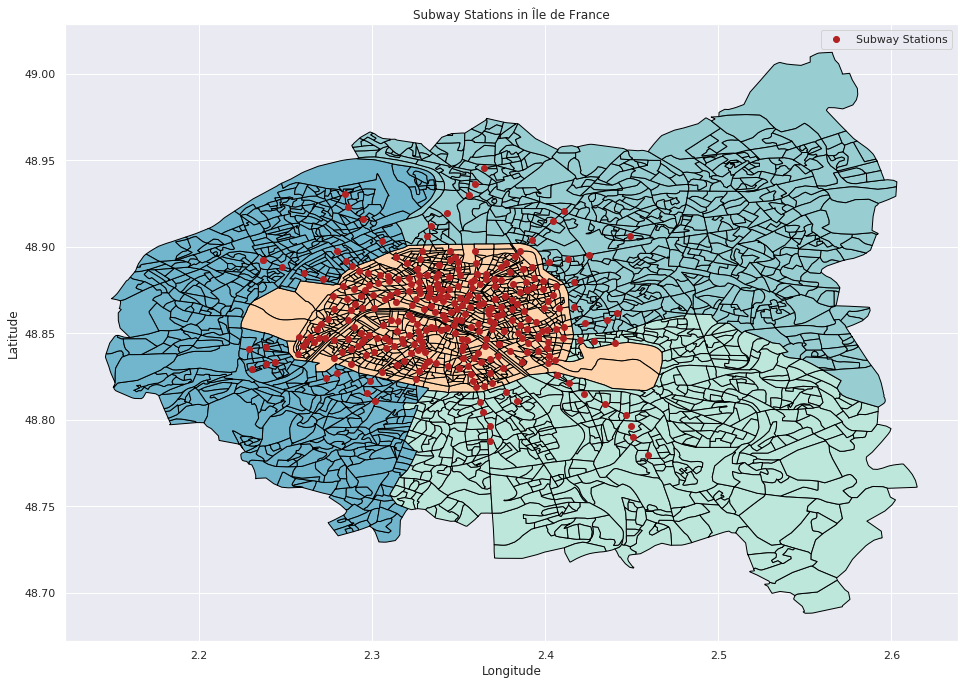

In [245]:
f, ax = plt.subplots(1, figsize=(16, 12))
ax = contour_iris[contour_iris['dep'].isin([75, 92, 93, 94])].plot(
    ax=ax, edgecolor='black', column='dep', cmap='icefire_r')
ax.scatter(station_data[station_data['id'].isin(subway_stations)]['x'],
           station_data[station_data['id'].isin(subway_stations)]['y'], color='firebrick', label='Subway Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Subway Stations in Île de France')
ax.legend()

plt.show();

### Min Max Normalization

Below we apply ``Min Max Normalization`` to data, with a scale range of $[0, 1]$.

In [246]:
data_matrix_6h = pd.Panel(normalize(matrix_6h), 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("6h")
                        )

data_matrix_2h = pd.Panel(normalize(matrix_2h), 
                         items=dates, 
                         major_axis=subway_stations, 
                         minor_axis=generate_times("2h")
                        )

data_matrix_15m_complete = pd.Panel(matrix_15m, 
                                    items=dates, 
                                    major_axis=subway_stations, 
                                    minor_axis=generate_times("15min")
                                   )

Delete the first $4$ hours, from $00.00.00$ to $04.00.00$ because it's useless, the number of validations in that range is mostly equal to 0.

In [247]:
del_hours = 0

In [248]:
data_matrix_15m = data_matrix_15m_complete.iloc[:, :, del_hours*4:]

In [249]:
data_matrix_15m.to_frame().head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
major minor                                                                  
198   00:00:00        38.0        70.0        57.0        26.0        26.0   
      00:15:00        20.0        49.0        67.0        13.0        10.0   
      00:30:00        13.0        39.0        48.0        18.0         4.0   
      00:45:00         3.0        43.0        61.0         3.0         2.0   
      01:00:00         1.0        23.0        48.0         0.0         0.0   

                2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  \
major minor                                                                  
198   00:00:00        39.0        46.0        53.0        46.0        70.0   
      00:15:00        20.0        31.0        30.0        29.0        84.0   
      00:30:00         4.0         9.0        26.0        33.0        50.0   
      00:45:00         6.0         4.0         7.0        33.0        24.0   
      01:00:00         2.0         3.0         1.0        25.0        25.0   

                ...  2015-12-22  2015-12-23  2015-12-24  2015-12-25  \
major minor     ...                                                   
198   00:00:00  ...        26.0        20.0        21.0        12.0   
      00:15:00  ...        14.0        23.0        21.0        19.0   
      00:30:00  ...        13.0         5.0         2.0        11.0   
      00:45:00  ...         4.0         5.0         9.0        10.0   
      01:00:00  ...         5.0         2.0         5.0         1.0   

                2015-12-26  2015-12-27  2015-12-28  2015-12-29  2015-12-30  \
major minor                                                                  
198   00:00:00        35.0        11.0        11.0        27.0        29.0   
      00:15:00        36.0        14.0        17.0        11.0        18.0   
      00:30:00        22.0         8.0        13.0        36.0        12.0   
      00:45:00         6.0         1.0         2.0         2.0         3.0   
      01:00:00         9.0         2.0         1.0         2.0         2.0   

                2015-12-31  
major minor                 
198   00:00:00         0.0  
      00:15:00         0.0  
      00:30:00         0.0  
      00:45:00         0.0  
      01:00:00         0.0  

[5 rows x 92 columns]

In [250]:
dmatrix_mean_6h = data_matrix_6h.mean()
dmatrix_mean_2h = data_matrix_2h.mean()
dmatrix_mean_15m = data_matrix_15m.mean()

dtmatrix_mean_6h = dmatrix_mean_6h.transpose()
dtmatrix_mean_2h = dmatrix_mean_2h.transpose()
dtmatrix_mean_15m = dmatrix_mean_15m.transpose()

Again, this is another way to print the stations with a small number of validations.

In [251]:
data_matrix_15m.mean(axis=0)[data_matrix_15m.mean(axis=0).sum(axis=1) < 810];

In [252]:
dmatrix_mean_15m.head()
dtmatrix_mean_15m.head()

2015-10-01  2015-10-02  2015-10-03  2015-10-04  2015-10-05  \
00:00:00   36.481848   53.389439   75.155116   19.254125   20.247525   
00:15:00   28.102310   46.851485   69.412541   14.712871   14.689769   
00:30:00   18.356436   37.458746   62.561056   12.412541    9.049505   
00:45:00    8.052805   29.128713   52.521452    4.584158    4.171617   
01:00:00    2.587459   23.132013   46.643564    1.920792    1.768977   

          2015-10-06  2015-10-07  2015-10-08  2015-10-09  2015-10-10  ...  \
00:00:00   27.996700   31.950495   38.940594   55.052805   63.435644  ...   
00:15:00   20.224422   24.848185   31.382838   50.775578   60.805281  ...   
00:30:00   12.963696   15.481848   19.828383   40.574257   51.204620  ...   
00:45:00    5.821782    6.333333    8.603960   30.920792   40.554455  ...   
01:00:00    1.943894    2.069307    2.422442   25.405941   35.693069  ...   

          2015-12-22  2015-12-23  2015-12-24  2015-12-25  2015-12-26  \
00:00:00   34.145215   29.422442   21.141914   16.544554   29.531353   
00:15:00   28.765677   24.570957   20.815182   14.442244   27.132013   
00:30:00   20.867987   17.425743   17.937294   11.023102   24.696370   
00:45:00    8.716172    7.933993   12.669967    7.858086   17.557756   
01:00:00    2.640264    2.557756    8.993399    5.201320   12.785479   

          2015-12-27  2015-12-28  2015-12-29  2015-12-30  2015-12-31  
00:00:00   19.092409   24.069307   30.462046   31.683168    0.026403  
00:15:00   18.973597   21.132013   25.815182   27.603960    0.016502  
00:30:00   12.749175   15.009901   18.755776   20.019802    0.036304  
00:45:00    5.709571    6.425743    8.336634    9.696370    0.013201  
01:00:00    2.092409    2.343234    2.570957    3.079208    0.003300  

[5 rows x 92 columns]

00:00:00   00:15:00   00:30:00   00:45:00   01:00:00   01:15:00  \
2015-10-01  36.481848  28.102310  18.356436   8.052805   2.587459   0.495050   
2015-10-02  53.389439  46.851485  37.458746  29.128713  23.132013  19.742574   
2015-10-03  75.155116  69.412541  62.561056  52.521452  46.643564  41.693069   
2015-10-04  19.254125  14.712871  12.412541   4.584158   1.920792   0.455446   
2015-10-05  20.247525  14.689769   9.049505   4.171617   1.768977   0.435644   

             01:30:00   01:45:00  02:00:00  02:15:00  ...   21:30:00  \
2015-10-01   0.214521   0.165017  0.105611  0.168317  ...  70.927393   
2015-10-02  15.320132   6.973597  2.069307  0.491749  ...  78.590759   
2015-10-03  37.009901  23.323432  8.752475  2.306931  ...  82.211221   
2015-10-04   0.165017   0.059406  0.092409  0.059406  ...  43.570957   
2015-10-05   0.227723   0.108911  0.085809  0.099010  ...  61.039604   

             21:45:00   22:00:00   22:15:00   22:30:00   22:45:00   23:00:00  \
2015-10-01  66.881188  65.399340  60.584158  60.755776  64.207921  75.128713   
2015-10-02  73.495050  70.907591  65.983498  66.211221  62.917492  66.330033   
2015-10-03  77.181518  73.755776  72.805281  74.570957  76.264026  83.947195   
2015-10-04  43.818482  41.745875  37.462046  36.722772  37.283828  52.759076   
2015-10-05  52.346535  53.125413  46.059406  45.498350  41.036304  41.254125   

             23:15:00   23:30:00   23:45:00  
2015-10-01  64.590759  52.138614  43.818482  
2015-10-02  63.188119  57.755776  54.673267  
2015-10-03  80.049505  76.587459  72.772277  
2015-10-04  37.158416  31.211221  25.254125  
2015-10-05  35.336634  28.003300  22.801980  

[5 rows x 96 columns]

### With Outliers

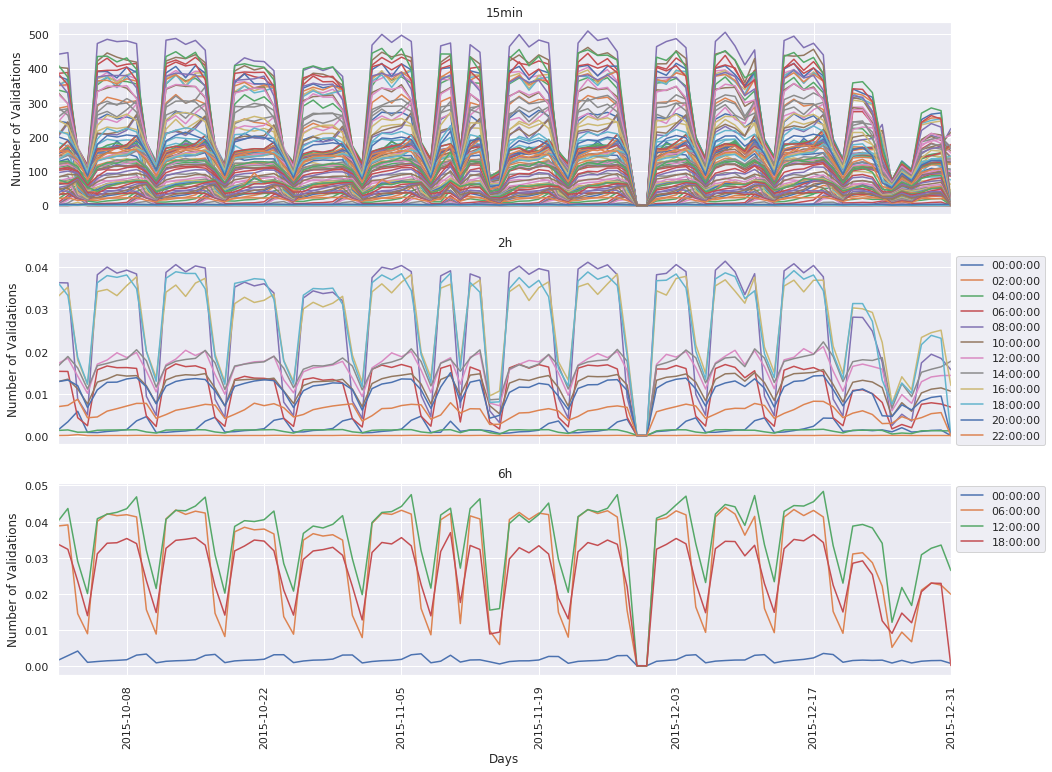

In [253]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Number of Validations')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01))

plt.xticks(rotation=90)
plt.show();

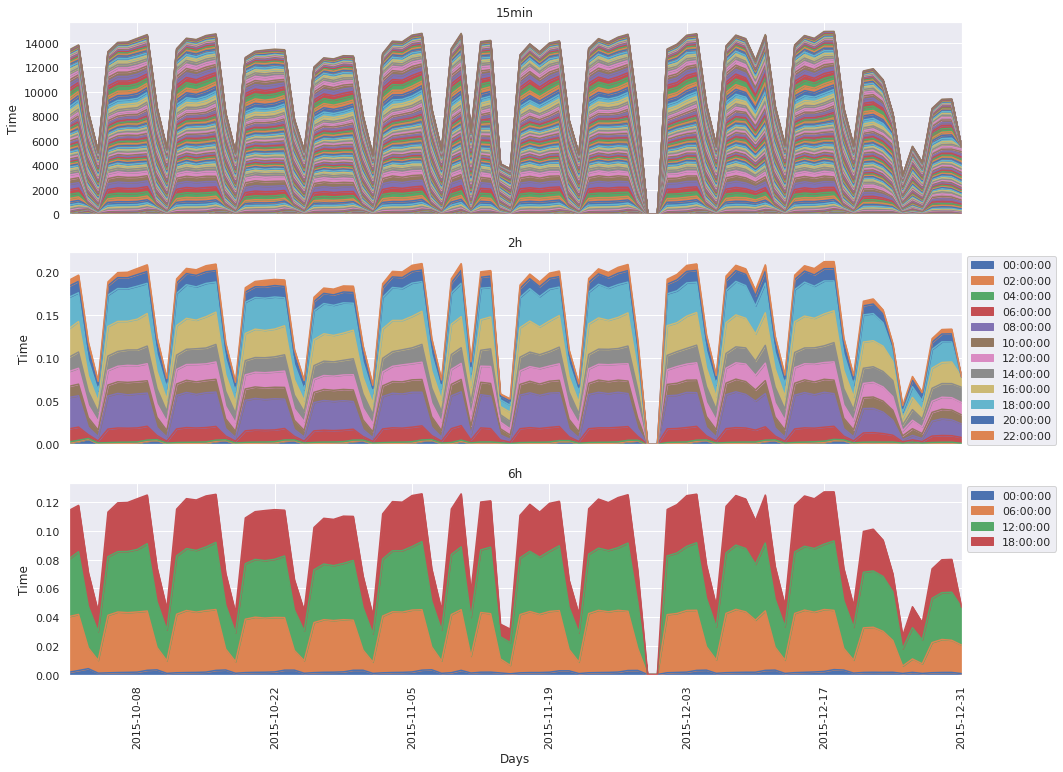

In [254]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dtmatrix_mean_15m.plot.area(ax=ax[0], legend=False)
ax1.set_xticklabels([])
ax1.set_ylabel('Time')
ax1.set_title('15min')

ax2 = dtmatrix_mean_2h.plot.area(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Time')
ax2.set_title('2h')
ax2.legend(bbox_to_anchor=(1., 1.01))

ax3 = dtmatrix_mean_6h.plot.area(ax=ax[2])
ax3.set_xlabel('Days')
ax3.set_ylabel('Time')
ax3.set_title('6h')
ax3.legend(bbox_to_anchor=(1., 1.01), loc=2)

plt.xticks(rotation=90)
plt.show();

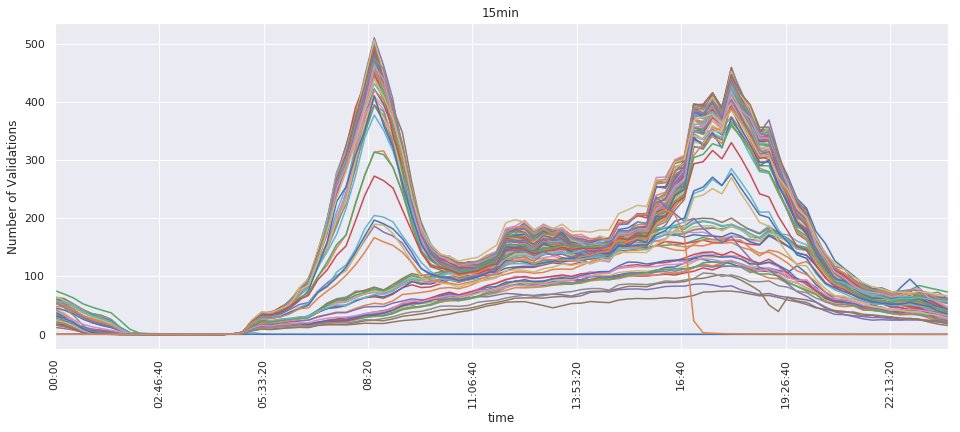

In [255]:
fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0])
dmatrix_mean_15m.plot(ax=ax, legend=False)
plt.ylabel('Number of Validations')
plt.title('15min')

plt.xticks(rotation=90)
plt.show();

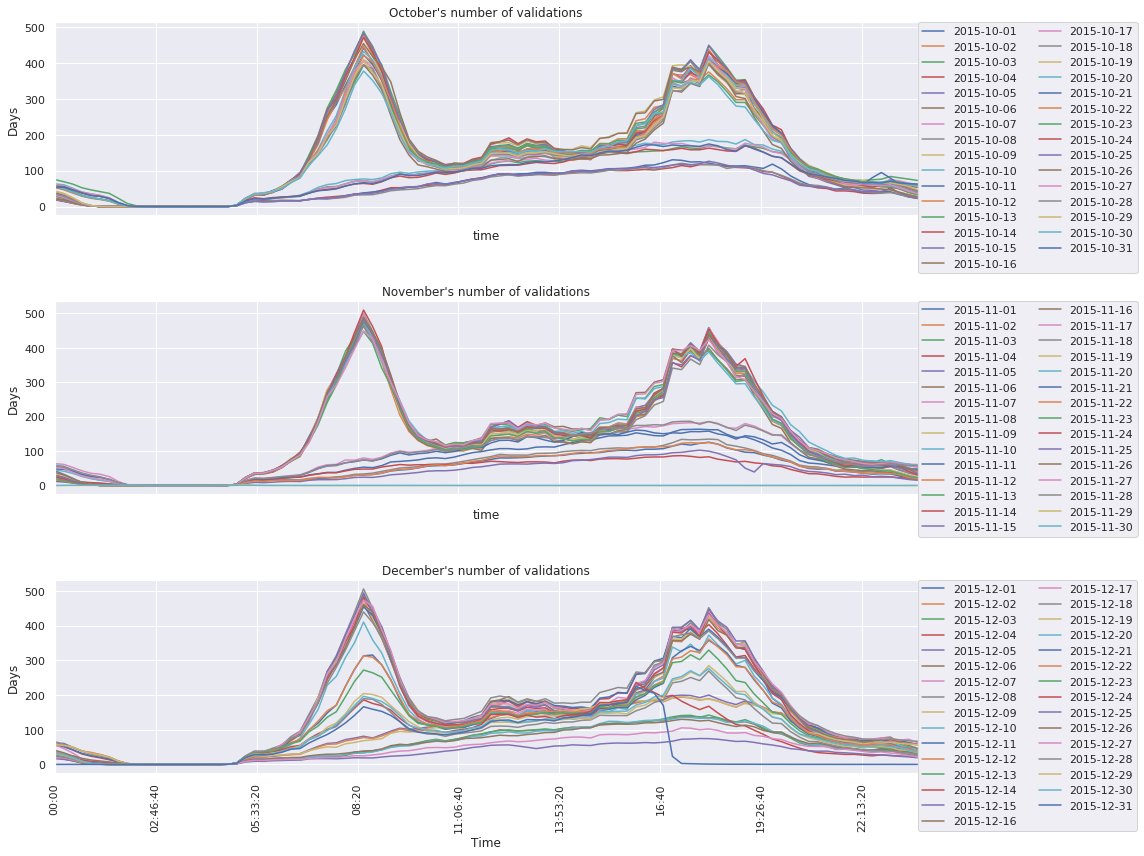

In [256]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = dmatrix_mean_15m.iloc[:, :31].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Days')
ax1.set_title('October\'s number of validations')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)


ax2 = dmatrix_mean_15m.iloc[:, 31:61].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Days')
ax2.set_title('November\'s number of validations')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = dmatrix_mean_15m.iloc[:, 61:].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Days')
ax3.set_title('December\'s number of validations')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

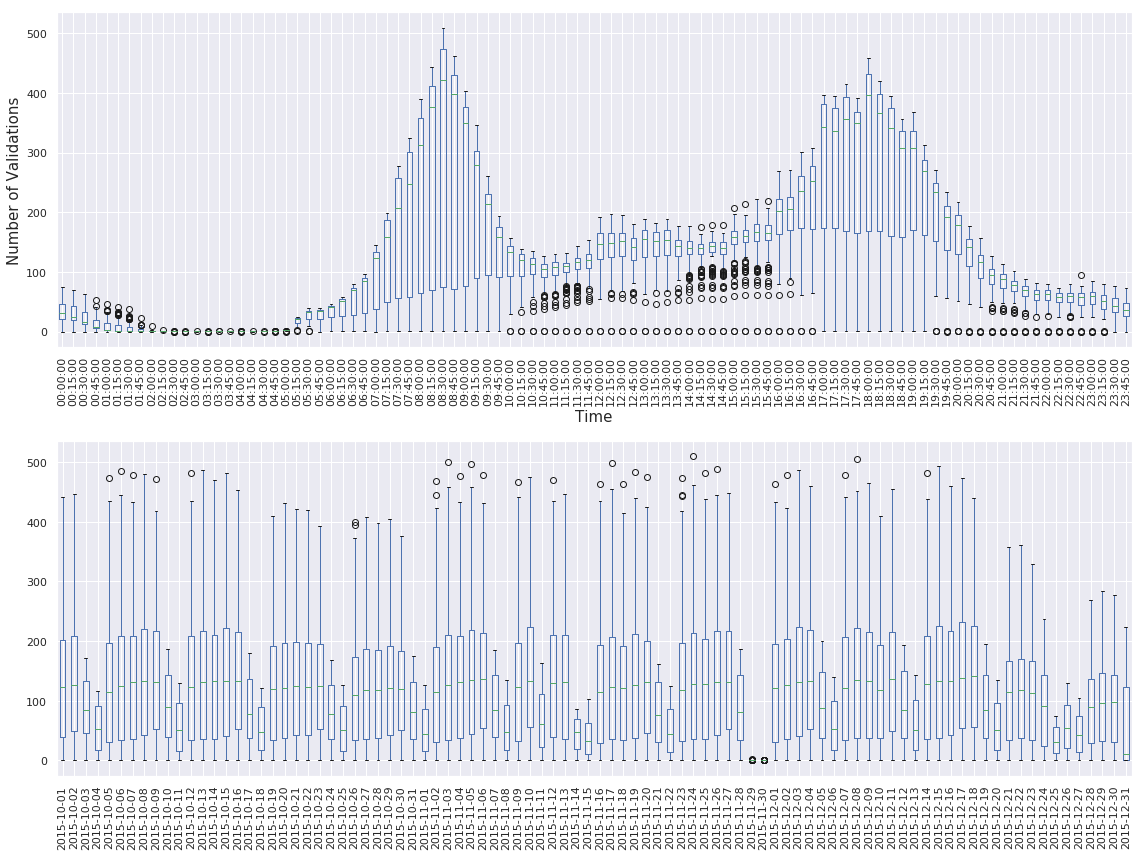

In [257]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = dtmatrix_mean_15m.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = dmatrix_mean_15m.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

### Defining useful variables

In [258]:
def sep_days(dico, diff_days=7):
    """ 
    
    :param dico:
    :param diff_days:
    :return:
    :rtype:
    
    """
    
    return {d: dict(filter(lambda dd: dd[1].weekday() == d,
                        zip(dico, dico.values())))
              for d in range(diff_days)}


def sep_wde(dico, week="days"):
    """
    
    :param dico:
    :param week:
    :return:
    :rtype:
    
    """

    if week.lower() == "days":
        return dict(filter(lambda dd: dd[1].weekday() < 5, 
                        zip(dico, dico.values())))
    elif week.lower() == "end":
        return dict(filter(lambda dd: dd[1].weekday() >= 5, 
                        zip(dico, dico.values())))
    else:
        raise ValueError("Wrong value for parameter \"week\"\n \
        Only takes two differents values : \"days\" or \"end\"")

def sep_month(dico, month_num=10):
    """
    
    :param dico:
    :param month_num:
    :return:
    :rtype:
    
    """
    
    return dict(filter(lambda dd: dd[1].month == month_num, 
                       zip(dico, dico.values())))


def remove_anomalies(dico, anomalies):
    """
    
    :param dico:
    :param anomalies:
    :return:
    :rtype:
    
    """
    
    return dict(filter(lambda dd: dd[1] not in anomalies,
                       zip(dico, dico.values())))


In [259]:
dict_dates = { i: d for i, d in zip(range(len(dates)), dates)}
ddict_days = sep_days(dict_dates, diff_days=7)

dict_wd = sep_wde(dict_dates, week="days")
dict_we = sep_wde(dict_dates, week="end")

dict_wd_oct = sep_month(dict_wd, 10)
dict_wd_nov = sep_month(dict_wd, 11)
dict_wd_dec = sep_month(dict_wd, 12)

nov_del = [date(2015, 11, 11), date(2015, 11, 29), date(2015, 11, 30)]
vacs = pd.date_range(start="2015-12-21", end="2015-12-31").date.tolist()
to_del = nov_del + vacs

dict_w = remove_anomalies(dict_dates, to_del)
dict_wd_final = remove_anomalies(dict_wd, to_del)                         

dict_wd_octf = sep_month(dict_wd_final, 10)
dict_wd_novf = sep_month(dict_wd_final, 11)
dict_wd_decf = sep_month(dict_wd_final, 12)

In [260]:
wd_15m = data_matrix_15m.loc[dict_w.values()]
wdm_15m = wd_15m.mean()
wdmt_15m = wdm_15m.transpose()

wd_15mf = data_matrix_15m.loc[dict_wd_final.values()]
wdm_15mf = wd_15mf.mean()
wdmt_15mf = wdm_15mf.transpose()

### Without outliers

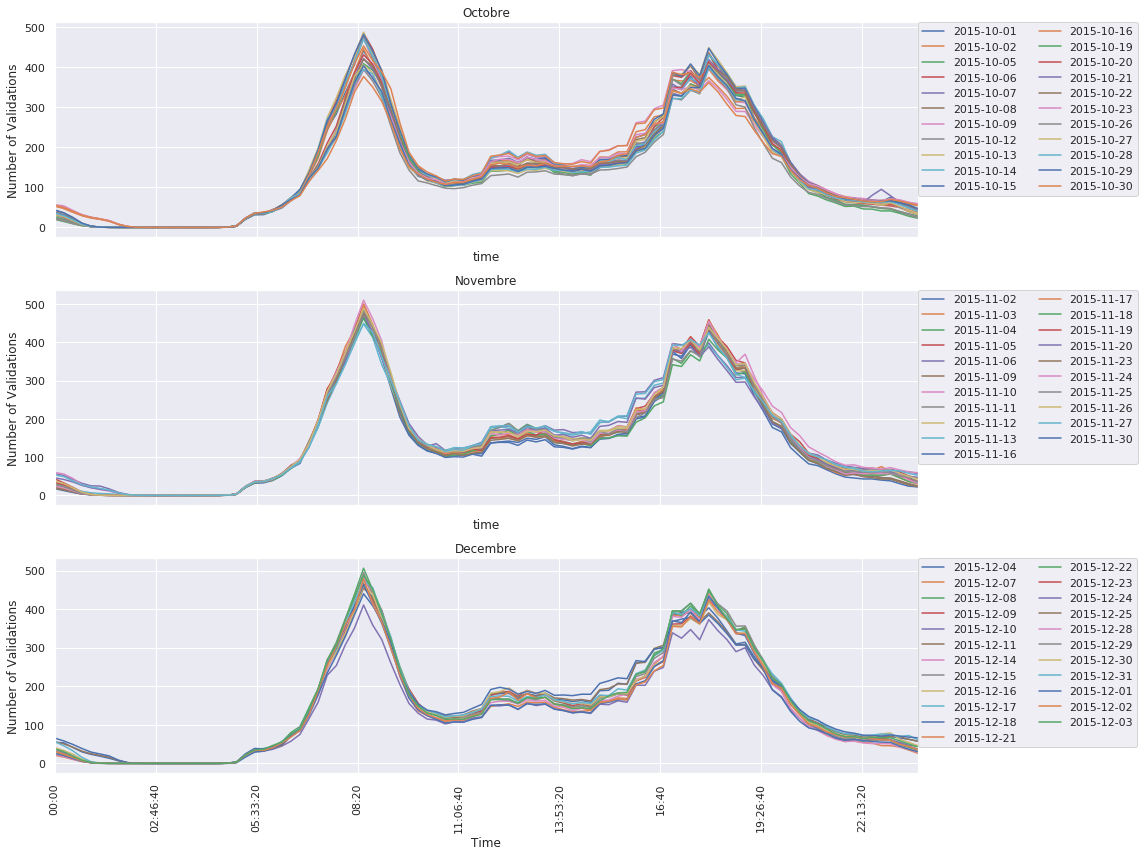

In [261]:
f, ax = plt.subplots(3, figsize=(16, 12))
ax1 = wdm_15m.loc[:, dict_wd_oct.values()].plot(ax=ax[0])
ax1.set_xticklabels([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Octobre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)


ax2 = wdm_15m.loc[:, dict_wd_nov.values()].plot(ax=ax[1])
ax2.set_xticklabels([])
ax2.set_ylabel('Number of Validations')
ax2.set_title('Novembre')
ax2.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax3 = wdm_15m.loc[:, dict_wd_dec.values()].plot(ax=ax[2])
ax3.set_xlabel('Time')
ax3.set_ylabel('Number of Validations')
ax3.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

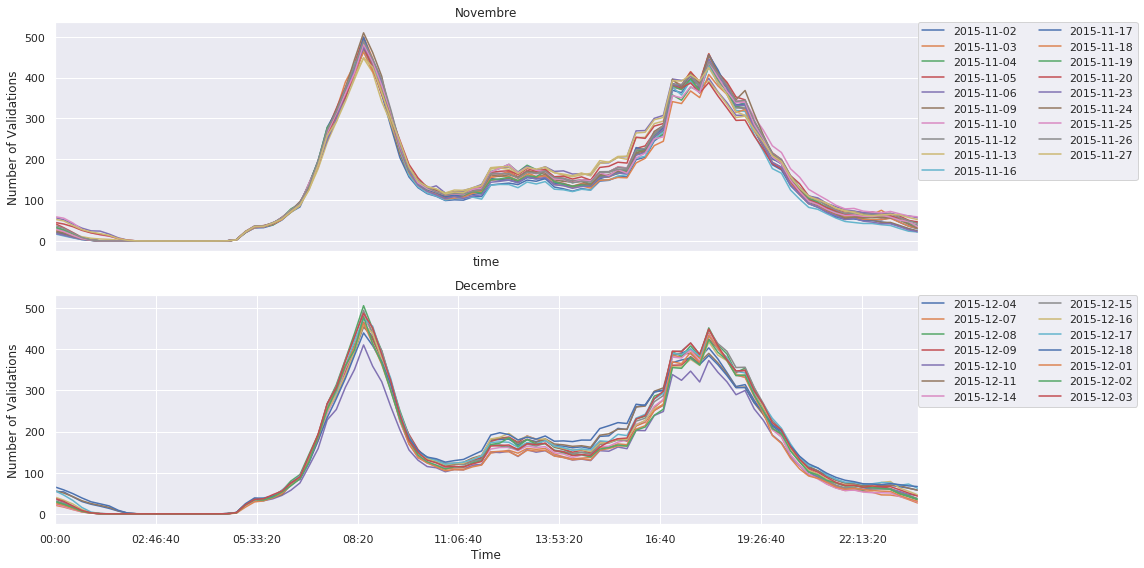

In [262]:
f, ax = plt.subplots(2, figsize=(16, 8))

ax1 = wdm_15mf.loc[:, dict_wd_novf.values()].plot(ax=ax[0])
ax1.set_xticks([])
ax1.set_ylabel('Number of Validations')
ax1.set_title('Novembre')
ax1.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

ax2 = wdm_15mf.loc[:, dict_wd_decf.values()].plot(ax=ax[1])
ax2.set_xlabel('Time')
ax2.set_ylabel('Number of Validations')
ax2.set_title('Decembre')
plt.legend(bbox_to_anchor=(1., 0.9, 1.1, .102), loc=2,
           ncol=2, borderaxespad=0.)
plt.tight_layout()

plt.show();

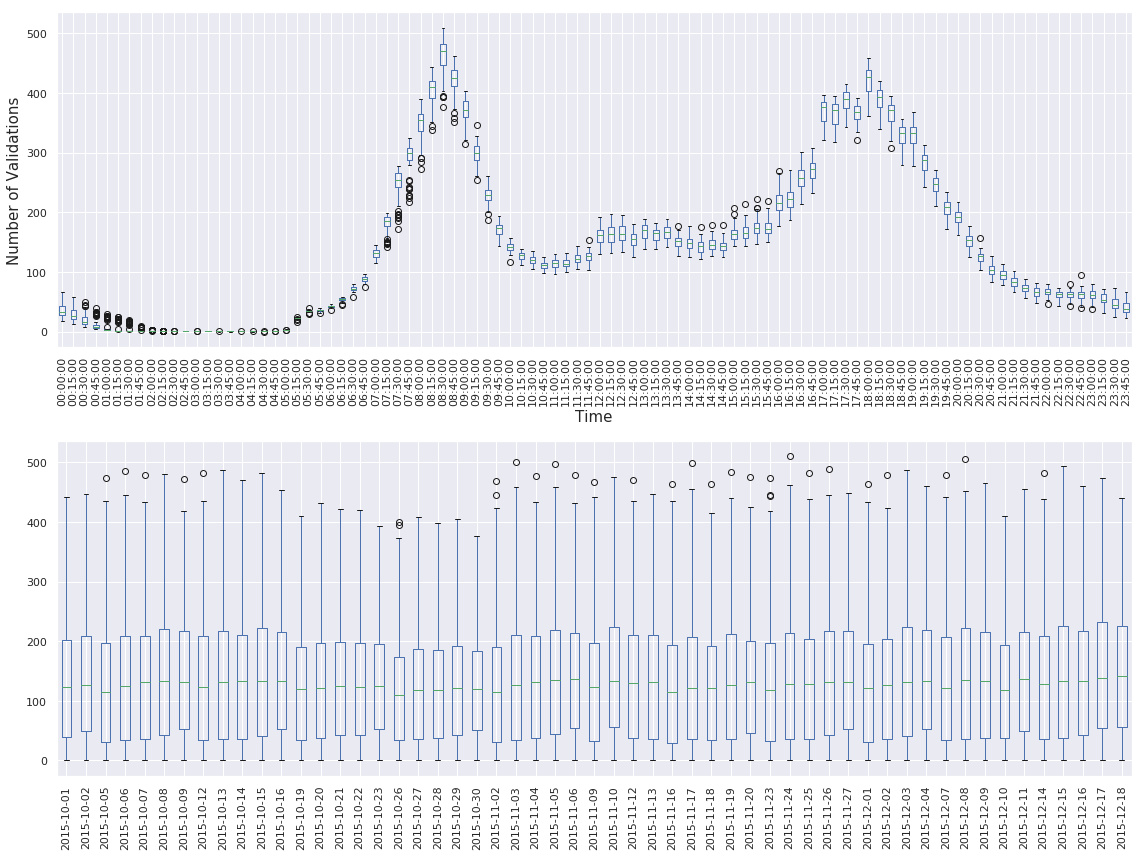

In [263]:
f, ax = plt.subplots(2, figsize=(16, 12))

ax1 = wdmt_15mf.boxplot(return_type='both', ax=ax[0])
ax[0].set_xlabel("Time", fontsize=15)
ax[0].set_ylabel("Number of Validations", fontsize=15)

for tick in ax[0].get_xticklabels():
    tick.set_rotation(90)

ax2 = wdm_15mf.boxplot(return_type='both', ax=ax[1])
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

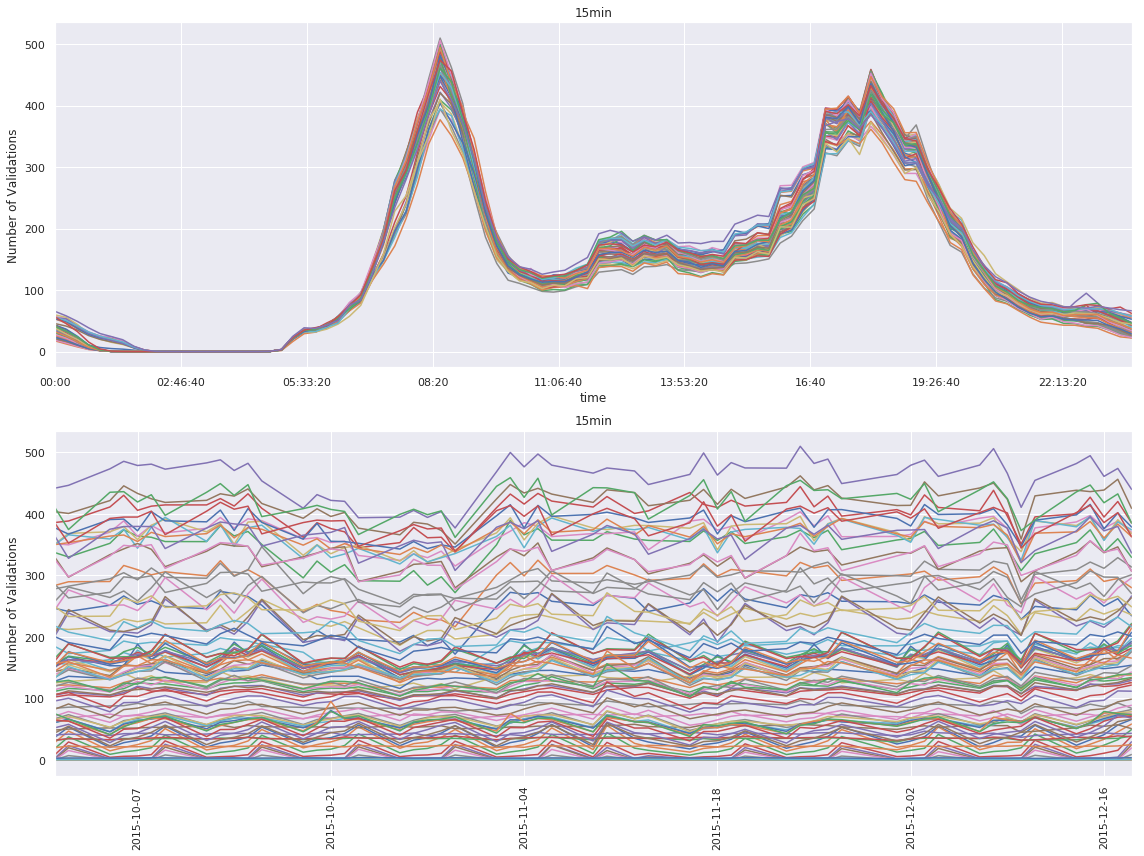

In [264]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

wdm_15mf.plot(ax=ax1, legend=False)
ax1.set_ylabel('Number of Validations'); ax1.set_title('15min')

ax2 = wdmt_15mf.plot(ax=ax2, legend=False)
ax2.set_ylabel('Number of Validations'); ax2.set_title('15min')

plt.xticks(rotation=90)
plt.tight_layout()

plt.show();

### Autocorrelation Plots

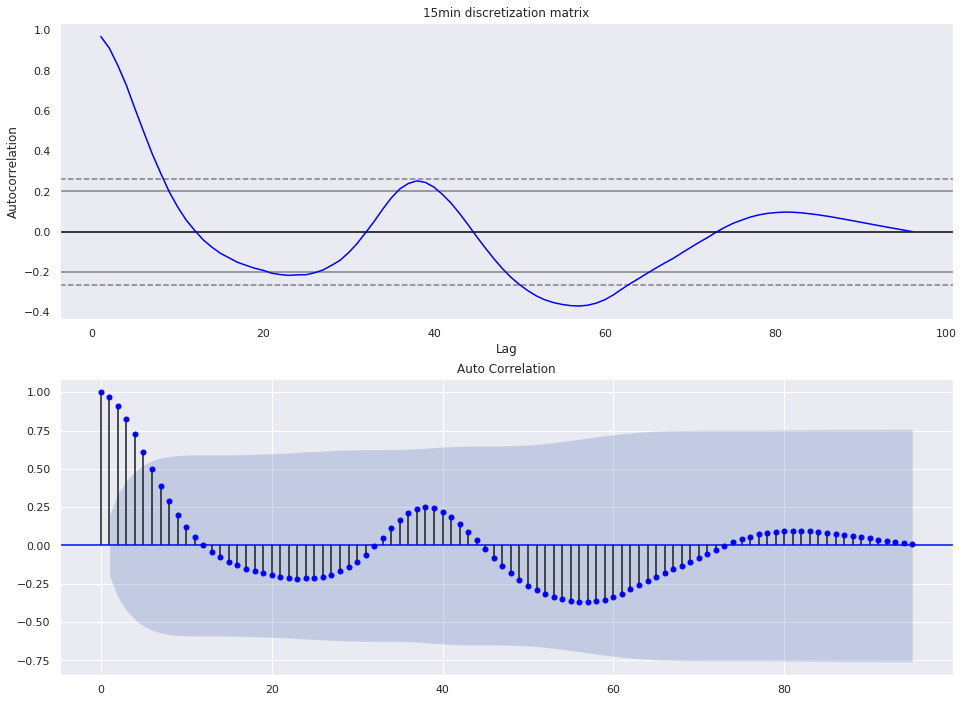

In [265]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 12))

autocorrelation_plot(wdmt_15mf.mean(), ax=ax1, c='blue')
ax1.set_title('15min discretization matrix')

plot_acf(wdmt_15mf.mean(), ax=ax2, c='blue', title='Auto Correlation')

plt.show();

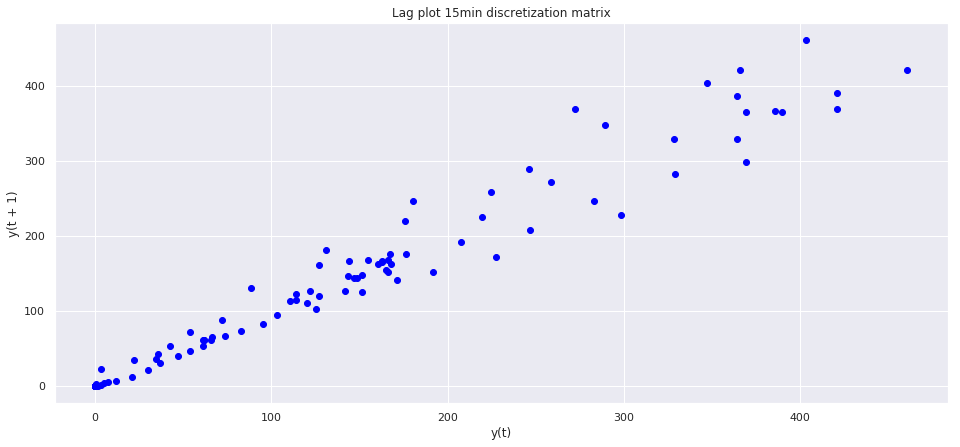

In [266]:
plt.figure(figsize=(16, 7))

lag_plot(wdmt_15mf.mean(), c='blue')
plt.title('Lag plot 15min discretization matrix')

# plot_pacf(wdmt_15mf.mean(), ax=ax[1], c='blue', title='Partial Auto Correlation')

plt.show();

### Splitting Data into Train and Test

In [267]:
dico = dict_wd
size = 45

In [268]:
X = data_matrix_15m.loc[dico.values()]
Xm = X.mean()
Xmt = Xm.transpose()

In [269]:
kw = list(dico.keys())
np.random.shuffle(kw)

vw = [dico[i] for i in kw]

In [270]:
ind_train = vw[:size]
ind_test = vw[size:]
X_train = X[ind_train]
X_test = X[ind_test]

In [271]:
X_train
X_test

<class 'pandas.core.panel.Panel'>
Dimensions: 45 (items) x 303 (major_axis) x 96 (minor_axis)
Items axis: 2015-12-03 to 2015-10-07
Major_axis axis: 198 to 60982
Minor_axis axis: 00:00:00 to 23:45:00

<class 'pandas.core.panel.Panel'>
Dimensions: 21 (items) x 303 (major_axis) x 96 (minor_axis)
Items axis: 2015-11-30 to 2015-11-09
Major_axis axis: 198 to 60982
Minor_axis axis: 00:00:00 to 23:45:00

## Models

In [272]:
class Regressor:
    def __init__(self):
        raise NotImplementedError("Please Implement this method")
        
    def datax_decorator(fonc):
        def reshape_data(self, datax, *args, **kwargs):
            """ Reshape data into one single matrix in order to apply analytic
            solution.

            :param datax: contient tous les exemples du dataset
            :returns: void
            :rtype: None

            """
            
            if datax.ndim == 3:
                X = datax.iloc[:, :, 0:self.order].values.reshape(-1, self.order)
                y = datax.iloc[:, :, self.order].values.T.reshape(-1, 1)
                for t in range(1, datax.shape[2] - self.order):
                    X = np.vstack((
                        X, 
                        datax.iloc[:, :, t:t+self.order].values.reshape(-1, self.order)))
                    y = np.vstack((
                        y, 
                        datax.iloc[:, :, t+self.order].values.T.reshape(-1, 1)))

                return fonc(self, (X, y), *args, **kwargs)
            elif datax.ndim == 2:
                X = datax.iloc[:, 0:self.order].values.reshape(-1, self.order)
                y = datax.iloc[:, self.order].values.reshape(-1, 1)
                for t in range(1, datax.shape[1] - self.order):
                    X = np.vstack((
                        X, 
                        datax.iloc[:, t:t+self.order].values.reshape(-1, self.order)))
                    y = np.vstack((y, 
                                   datax.iloc[:, t+self.order].values.reshape(-1, 1)))

                return fonc(self, (X, y), *args, **kwargs)
            elif datax.ndim == 1:
                # TODO 
                pass
            else:
                raise ValueError("Untreated datax number of dimensions")
        
        return reshape_data    
        
    def fit(self):
        raise NotImplementedError("Please Implement this method")
        
    def predict(self):
        raise NotImplementedError("Please Implement this method")
        
    def score(self):
        raise NotImplementedError("Please Implement this method")

### Baseline

In [273]:
class Baseline:
    def __init__(self, level=None, first_ndays=7):
        """ Initialization of Baseline parameters
        
        :param level: level of computing, means : if level is None the rmse is
        computed on the whole Train Set, if level is equal to "S", then the 
        metric is applied separatly for each station, if it is equal to "J", 
        it is applied separetly for each day : Lundi, Mardi, etc..., if it is
        equal to "SJ", then for each station and each day, we aggregate the
        values and compute the metric. And if level is none of the listed
        values above then, we consider that it is None, by default.
        
        :param first_ndays:
        :return:
        :rtype:
        
        """ 
        
        self.first_ndays = first_ndays
        self.level = level
        if self.level not in [None, "s", "S", "j", "J", "sj", "SJ", "Sj", "sJ"]:
            self.level = None   
        
    def fit(self, datax):
        """
        
        """
        
        if self.level is None:
            self.mean = datax.mean().mean(axis=1)
        elif self.level.lower() == "s":
            self.mean = datax.mean(axis=0)
        elif self.level.lower() == "j":
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean().mean(axis=1))                
        elif self.level.lower() == "sj":
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean(axis=0))
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    def predict(self, datax):
        """
        
        """
        
        if self.level is None:
            return datax.apply(lambda x: self.mean, axis="minor")        
        
        elif self.level.lower() == "s":
            return datax.apply(lambda x: self.mean, axis=(1, 2))
        
        elif self.level.lower() == "j":
            datax_copy = datax.copy()
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                # print(exist_ind, "\n")
                datax_copy.update(datax_copy[exist_ind].apply(
                    lambda x: self.mean[d], axis="minor"))
                
            return datax_copy
        
        elif self.level.lower() == "sj":
            datax_copy = datax.copy()
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                datax_copy.update(datax_copy[exist_ind].apply(
                    lambda x: self.mean[d], axis=(1, 2))) 
                
            return datax_copy
        
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
          
    def score(self, datax):
        """
        
        """
        
        return np.sqrt(((datax.values - self.predict(datax).values)**2).mean())

In [288]:
limit_t = 16
levels = ["None", "s", "j", "sj"]
baseline_scores = []
baseline_preds = []
for level in levels:
    b = Baseline(level=level, first_ndays=5)
    b.fit(X_train)
    baseline_preds.append(b.predict(X_test))
    baseline_scores.append(np.array([b.score(X_test)]).repeat(limit_t))

In [289]:
pd_baseline = pd.DataFrame(np.array(baseline_scores), index=levels, columns=range(limit_t))

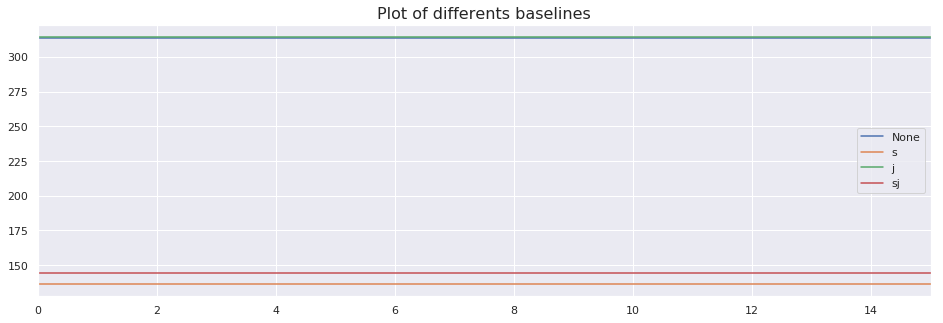

In [290]:
pd_baseline.T.plot(figsize=(16, 5))
plt.title("Plot of differents baselines", fontsize=16);

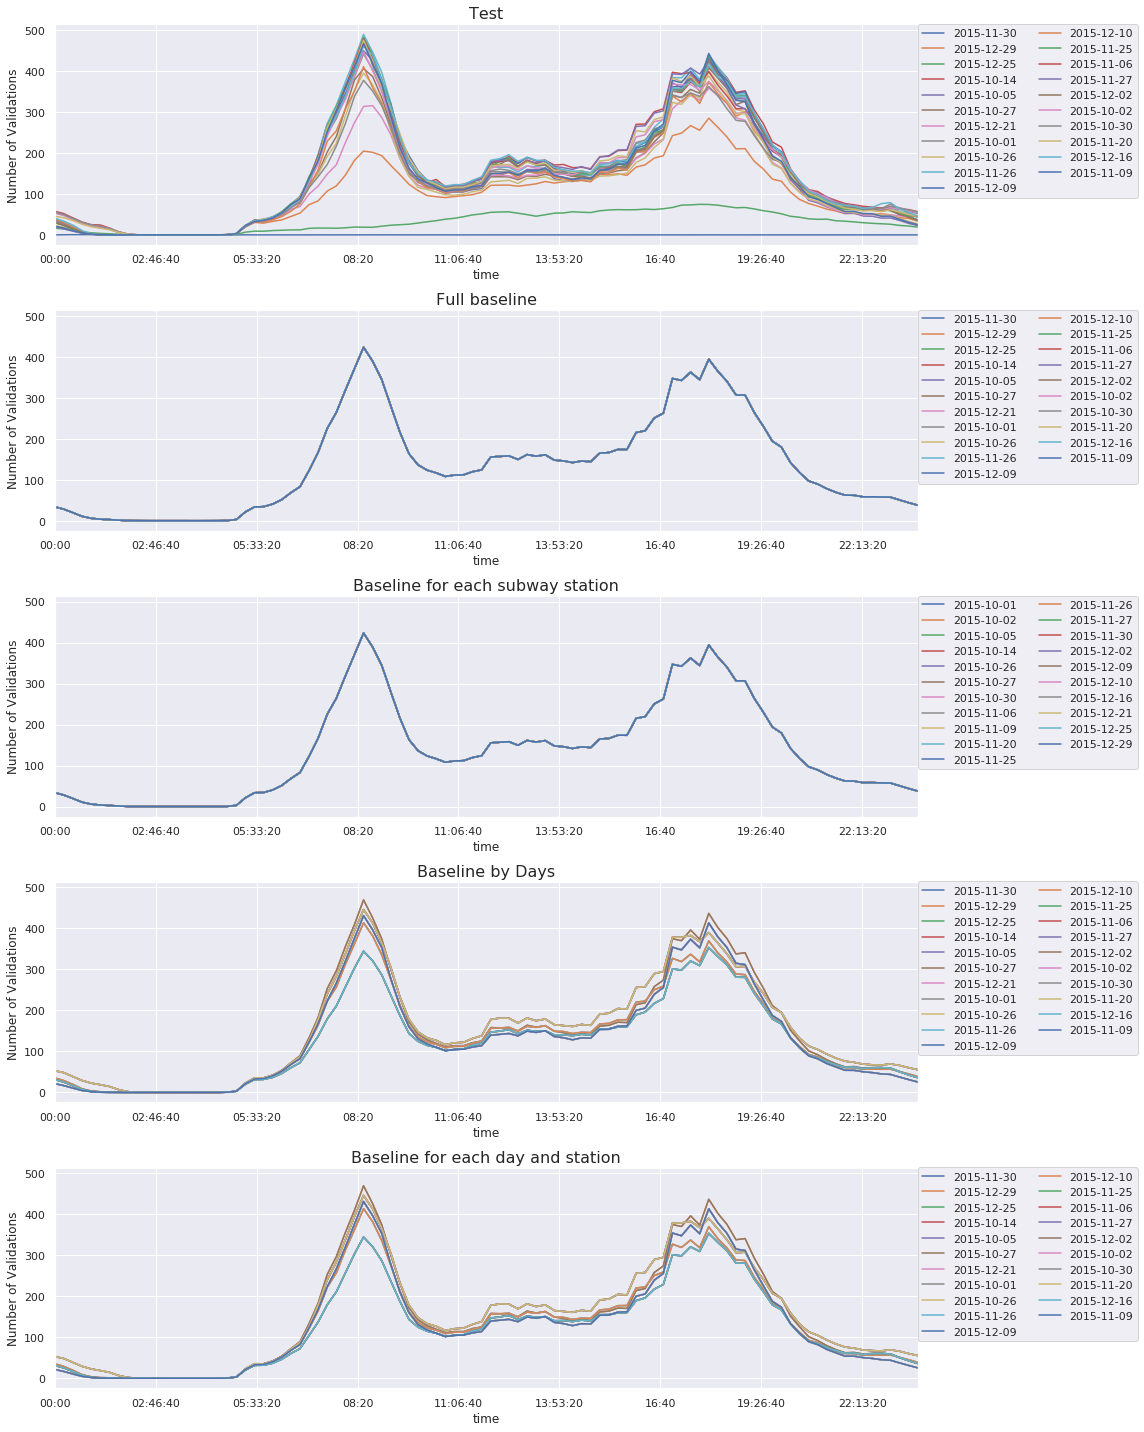

In [291]:
fig, ax = plt.subplots(5, figsize=(16, 20))

X_test.mean().plot(ax=ax[0])
ax[0].set_ylabel('Number of Validations')
ax[0].set_title('Test', fontsize=16)
ax[0].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

baseline_preds[0].mean().plot(ax=ax[1])
ax[1].set_ylabel('Number of Validations')
ax[1].set_title('Full baseline', fontsize=16)
ax[1].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)
ax[1].set_ylim(*ax[0].get_ylim())

baseline_preds[1].mean().plot(ax=ax[2])
ax[2].set_ylabel('Number of Validations')
ax[2].set_title('Baseline for each subway station', fontsize=16)
ax[2].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)
ax[2].set_ylim(*ax[0].get_ylim())

baseline_preds[2].mean().plot(ax=ax[3])
ax[3].set_ylabel('Number of Validations')
ax[3].set_title('Baseline by Days', fontsize=16)
ax[3].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)
ax[3].set_ylim(*ax[0].get_ylim())

baseline_preds[3].mean().plot(ax=ax[4])
ax[4].set_ylabel('Number of Validations')
ax[4].set_title('Baseline for each day and station', fontsize=16)
ax[4].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)
ax[4].set_ylim(*ax[0].get_ylim())

plt.tight_layout()
plt.show();

In [318]:
from cost_functions import mse, mse_g


class myAR(Regressor):
    def __init__(self, order=4, level=None, loss=mse, loss_g=mse_g, max_iter=1000,
                 eps=0.01):
        """ Initialisation des paramètres du perceptron

        :param order: Taille de la fenêtre glissante
        :param loss: fonction de coût
        :param loss_g: gradient de la fonction coût
        :param max_iter: nombre maximum d'itération de la fonction coût
        :param eps: pas du gradient


        """

        self.order = order
        self.max_iter, self.eps = max_iter, eps
        self.loss, self.loss_g = loss, loss_g
        self.w = np.random.random(self.order)
                      
    
    @Regressor.datax_decorator
    def analytic_fit(self, datax):
        """ Finds the optimal weigths analytically 
        
        :param datax: contient tous les exemples du dataset
        :returns: void
        :rtype: None
        
        """
        
        self.X, self.y = datax
        A, B = self.X.T.dot(self.X), self.X.T.dot(self.y)
        self.w = np.linalg.solve(A, B).ravel()
        display(HTML(pd.DataFrame(self.w.reshape(1, -1), index=['Weights'], 
                                  columns=range(len(self.w))).to_html()))
       

    def minibatch_fit(self, datax):
        """ Mini-Batch gradient descent Learning

        :param datax: contient tous les exemples du dataset
        
        """

        for _ in range(self.max_iter):
            for d in range(datax.shape[0]):
                for t in range(datax.shape[2] - self.order):
                    batchx = datax.iloc[d, :, t:t + self.order].values
                    batchy = datax.iloc[d, :, t + self.order].values
                    self.w -= (self.eps * self.loss_g(batchx, batchy, self.w))
                    
        # display(HTML(pd.DataFrame(self.w.reshape(1, -1), index=['Weights'], 
        #                          columns=range(len(self.w))).to_html()))

    def predict(self, datax):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :returns: predicted labels
        :rtype: numpy array

        """

        y_pred = []
        for d in range(datax.shape[0]):
            y_pred.append([])
            for t in range(datax.shape[2] - self.order):
                batchx = datax.iloc[d, :, t:t + self.order].values
                y_pred[d].append(batchx.dot(self.w.T))

        return np.array(y_pred).transpose(0, 2, 1)

    def forecast_n(self, datax):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :returns: predicted labels
        :rtype: numpy array

        """

        y_pred = []
        for d in range(datax.shape[0]):
            y_pred.append([])
            batchx = datax.iloc[d, :, 0:self.order].values
            for t in range(datax.shape[2] - self.order):
                next_y = batchx.dot(self.w.T)
                y_pred[d].append(next_y)
                batchx = np.hstack(
                    (batchx[:, 1:], np.array(next_y).reshape(-1, 1)))

        return np.array(y_pred).transpose(0, 2, 1)
    
    def transform_batchx(self, batchx, tplus):
        """
        """
        if tplus == 1:
            return batchx
        
        for _ in range(tplus-1):
            next_y = batchx.dot(self.w.T)
            if batchx.ndim == 2:
                batchx = np.hstack((batchx[:, 1:], 
                                    np.array(next_y).reshape(-1, 1)))
            elif batchx.ndim == 1:
                batchx = np.hstack((batchx[1:], next_y))
                
        return batchx
    
    
    def forecast(self, datax, tplus=None):
        """ Predict labels

        :param datax: contient tous les exemples du dataset
        :param tplus: if t equal to 2, means predicting what happened at t+2
        :returns: predicted labels
        :rtype: numpy array
        
        """
                
        if tplus == None or tplus > self.order:
            return self.forecast_n(datax)
        else:
            y_pred = []
            batch_ind = self.order - tplus
            
            if datax.ndim == 3:
                for d in range(datax.shape[0]):
                    y_pred.append([])
                    # Take the first batch
                    batchx = datax.iloc[d, :, 0:self.order].values
                    # Predict till we finish the first round of tplus
                    for _ in range(tplus):
                        next_y = batchx.dot(self.w.T)
                        y_pred[d].append(next_y)
                        batchx = np.hstack((batchx[:, 1:], 
                                            np.array(next_y).reshape(-1, 1)))
                        
                    # After the first round of tplus, we have to replace some
                    # predicted values by the real ones and simultaneously 
                    # replace the following columns by t+1,..., tplus
                    for t in range(1, datax.shape[2] - self.order - tplus + 1): 
                        batchx = self.transform_batchx(
                            datax.iloc[d, :, t:self.order+t].values, tplus)
                        next_y = batchx.dot(self.w.T)
                        # next_y = np.where(next_y < 0, 0, next_y)
                        y_pred[d].append(next_y)
                        
                        
            elif datax.ndim == 2:
                # TODO
                pass
            elif datax.ndim == 1:
                batchx = datax.iloc[0:self.order].values
                
                for _ in range(tplus):
                    next_y = batchx.dot(self.w.T)
                    y_pred.append(next_y)
                    batchx = np.hstack((batchx[1:], next_y))
                        
                for t in range(1, datax.shape[0] - self.order - tplus + 1):
                    batchx = self.transform_batchx(
                            datax.iloc[t:self.order+t].values, tplus)
                    next_y = batchx.dot(self.w.T)
                    # if next_y < 0: next_y = 0
                    y_pred.append(next_y)
                    
                return np.array(y_pred)
            else:
                raise ValueError("Untreated datax number of dimensions")
                                        
        return np.array(y_pred).transpose(0, 2, 1)
    

In [319]:
class theAR(Baseline):
    def __init__(self, level=None, first_ndays=7, **kwargs):
        """
        
        """
        
        super().__init__(level, first_ndays)
        self.kwargs = kwargs
        
    def fit(self, datax):
        """
        
        """
        
        if self.level is None:
            print("Fitting data...")
            self.model = myAR(**self.kwargs)
            self.model.analytic_fit(datax)
        elif self.level.lower() == "s":
            self.models = []            
            for s in range(datax.shape[1]):
                Xs = datax.iloc[:, s].T
                self.models.append(myAR(**self.kwargs))
                self.models[s].analytic_fit(Xs)
        elif self.level.lower() == "j":
            # TODO
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean().mean(axis=1))                
        elif self.level.lower() == "sj":
            # TODO
            self.mean = []
            for d in range(self.first_ndays):
                exist_ind = list(set(ddict_days[d].values()) & set(datax.items))
                self.mean.append(datax[exist_ind].mean(axis=0))
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def predict(self, datax, tplus=None):
        """
        
        """
        
        def predict_per_station(x, tplus):
            pred_s = []
            for s in range(x.shape[0]):
                pred_s.append(self.models[s].forecast(x.iloc[s], tplus))
            return np.array(pred_s)
        
        if self.level is None:
            return self.model.forecast(datax, tplus)
        elif self.level.lower() == "s":
            return datax.apply(
                lambda x: predict_per_station(x, tplus), axis=(1, 2))
        elif self.level.lower() == "j":
            # TODO
            pass
        elif self.level.lower() == "sj":
            # TODO
            pass
        else:
            raise ValueError("Unknown value for level attribute, \
            try: s, j, sj or None")
    
    
    def score(self, datax, tplus=None):
        """
        
        """
        
        X_pred = self.predict(datax, tplus)
        
        try:
            return np.sqrt(((X_pred - 
                         datax.iloc[:, :, self.model.order:].values)**2).mean())
        except:
            return np.sqrt(((X_pred.values - 
                         datax.iloc[:, :, self.models[0].order:].values)**2).mean())

    

In [320]:
def ar_plot_results(level, order, limit_t):
    """
    
    """
    
    ar_scores = []
    ar_preds = []
    ar = theAR(level=level, order=order)
    ar.fit(X_train)
    for t in range(1, limit_t+1):
        ar_preds.append(ar.predict(X_test, t))
        ar_scores.append(ar.score(X_test, t))
        
    return ar_scores, ar_preds

def create_panel_pred(ar_preds, t, order, del_hours=0):
    """
    
    """
    
    return pd.Panel(np.array(ar_preds[t-1]),
                      items=wd_testorder_15m.items, 
                      major_axis=subway_stations, 
                      minor_axis=generate_times("15min")[(del_hours*4)+order:]
                     )

### One AR for all

In [321]:
order = 16
limit_t = 16

In [322]:
%%time
ar_scores, ar_preds = ar_plot_results(None, order, limit_t)

Fitting data...


CPU times: user 19.8 s, sys: 1.48 s, total: 21.3 s
Wall time: 20.8 s


In [323]:
ar_scores

[71.3857530415289,
 102.70803167958921,
 139.6774557255455,
 172.90511297927242,
 207.97413722913427,
 237.39075767467077,
 261.86472671071397,
 281.5322680313725,
 297.9426828322672,
 309.86142493470186,
 318.4095577121636,
 324.62116375159377,
 329.67350290544783,
 333.3038333455904,
 336.05148835168904,
 338.00571379317097]

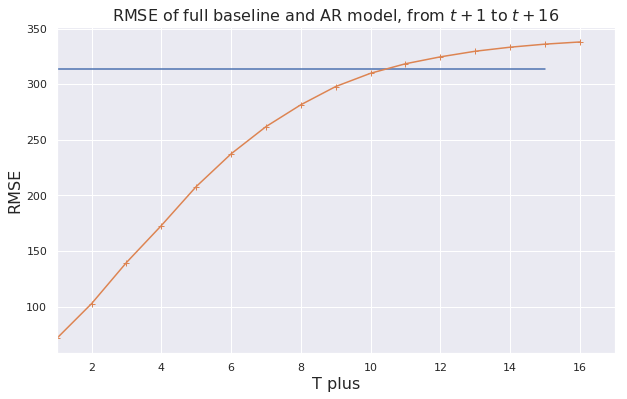

In [324]:
plt.figure(figsize=(10, 6))
xlim = (1, len(ar_scores)+1)
pd_baseline.iloc[0].plot(figsize=(10, 6), xlim=xlim)
plt.plot(range(*xlim), ar_scores, marker='+')
plt.xlim(*xlim)
plt.title("RMSE of full baseline and AR model, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

In [325]:
wd_testorder_15m = X_test.iloc[:, :, order:]
wdm_testorder_15m = wd_testorder_15m.mean()
wdmt_testorder_15m = wdm_testorder_15m.transpose()

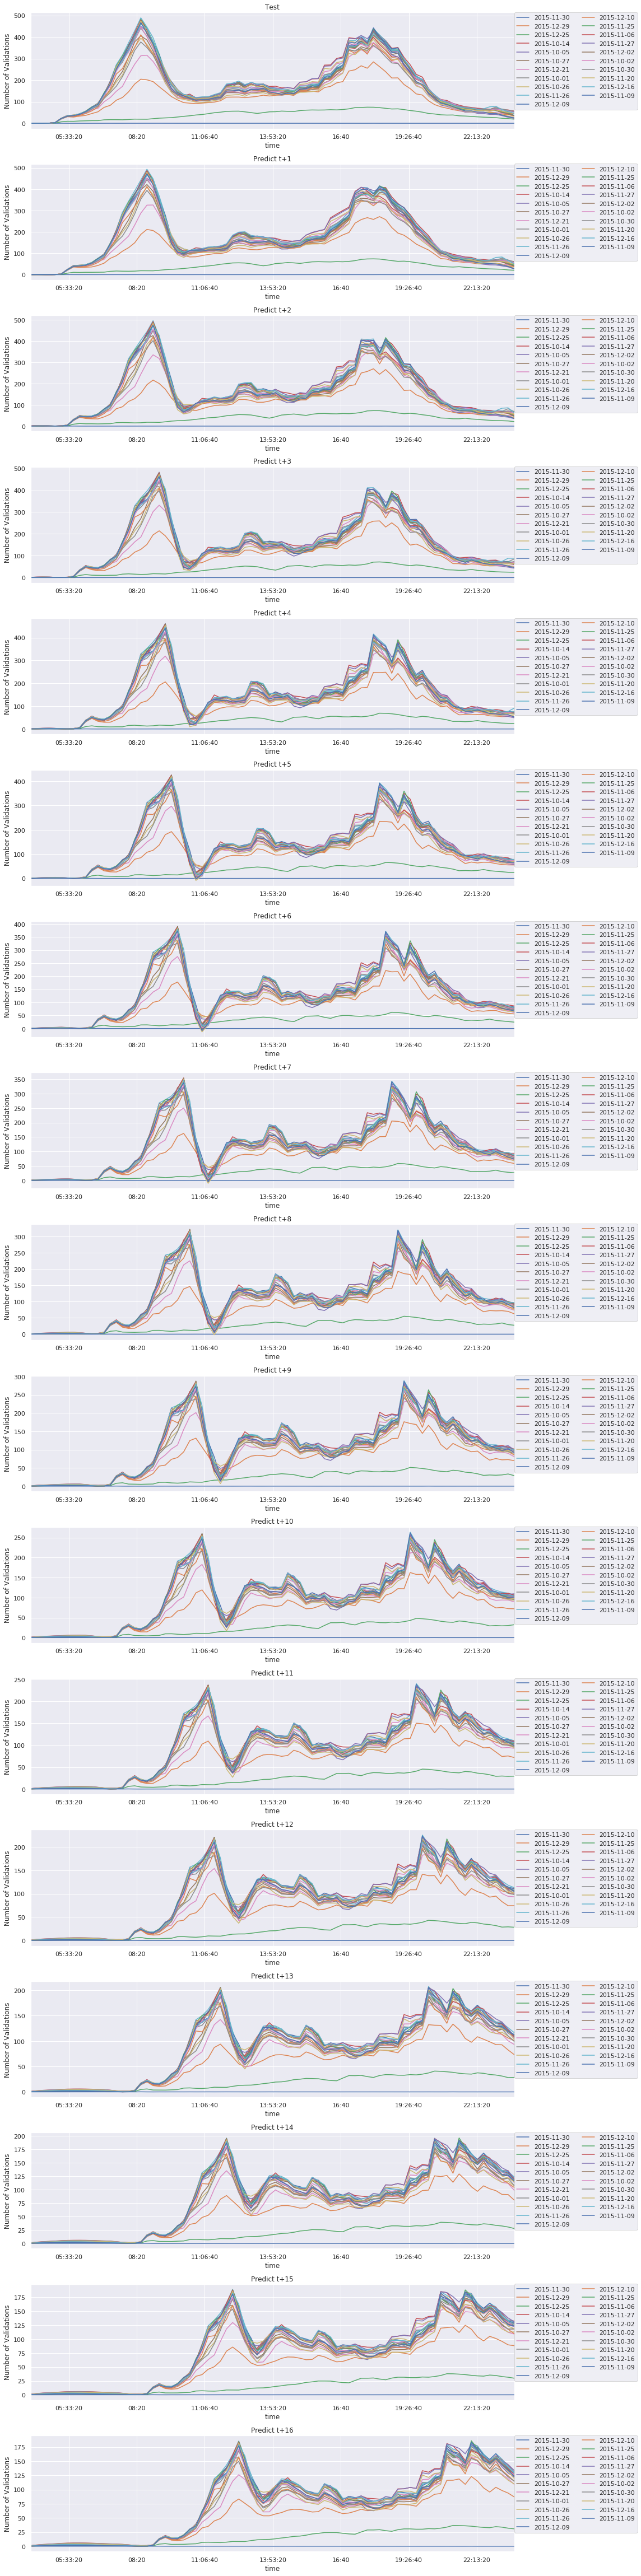

In [326]:
fig, ax = plt.subplots(limit_t+1, figsize=(16, limit_t*4))

wdm_testorder_15m.plot(ax=ax[0])
ax[0].set_ylabel('Number of Validations')
ax[0].set_title('Test')
ax[0].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

for i in range(1, limit_t+1):
    pred_t = create_panel_pred(ar_preds, i, order=order, del_hours=del_hours).mean()
    pred_t.plot(ax=ax[i])
    ax[i].set_ylabel('Number of Validations')
    ax[i].set_title("Predict t+{}".format(i))
    ax[i].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
                 borderaxespad=0.)
    # ax[i].set_ylim(*ax[0].get_ylim())

plt.tight_layout()
plt.show();

### AR per station

In [331]:
order = 4
limit_t = 4

In [332]:
%%time
ar_scores, ar_preds = ar_plot_results("s", order, limit_t)

KeyboardInterrupt: 

In [333]:
ar_scores

[226.4265087510889,
 233.58092660237858,
 244.66838874484952,
 257.9733305452928,
 273.95779564780673,
 288.9037003194617,
 302.22264496874885,
 313.3441037965332,
 323.08011153872917,
 330.61557562505186,
 336.07773216265036,
 340.2971521433498,
 343.6604306895254,
 346.16786839960463,
 348.0219605921291,
 349.38831501121024]

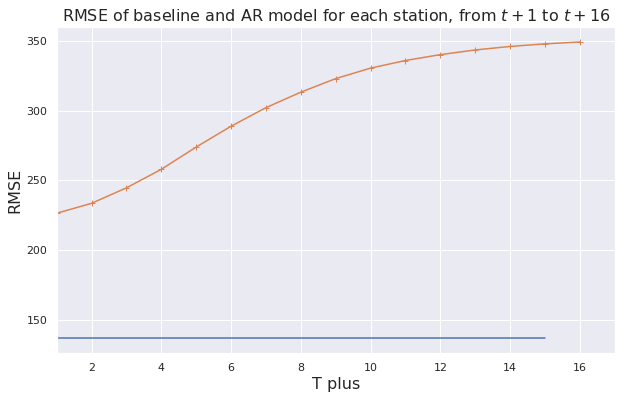

In [330]:
plt.figure(figsize=(10, 6))
xlim = (1, len(ar_scores)+1)
pd_baseline.iloc[1].plot(figsize=(10, 6), xlim=xlim)
plt.plot(range(*xlim), ar_scores, marker='+')
plt.xlim(*xlim)
plt.title("RMSE of baseline and AR model for each station, from $t+1$ to $t+{}$".format(limit_t), fontsize=16)
plt.xlabel("T plus", fontsize=16); plt.ylabel("RMSE", fontsize=16);

In [63]:
wd_testorder_15m = X_test.iloc[:, :, order:]
wdm_testorder_15m = wd_testorder_15m.mean()
wdmt_testorder_15m = wdm_testorder_15m.transpose()

In [64]:
fig, ax = plt.subplots(limit_t+1, figsize=(16, limit_t*4))

wdm_testorder_15m.plot(ax=ax[0])
ax[0].set_ylabel('Number of Validations')
ax[0].set_title('Test')
ax[0].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
           borderaxespad=0.)

for i in range(1, limit_t+1):
    pred_t = create_panel_pred(ar_preds, i, order=order, del_hours=5).mean()
    pred_t.plot(ax=ax[i])
    ax[i].set_ylabel('Number of Validations')
    ax[i].set_title("Predict t+{}".format(i))
    ax[i].legend(bbox_to_anchor=(1., 0.9, 1.1, .102), ncol=2, loc=2,
                 borderaxespad=0.)
    #ax[i].set_ylim(*ax[0].get_ylim())
    
plt.tight_layout()
plt.show();

SyntaxError: invalid syntax (<ipython-input-64-2abd1672d315>, line 1)

## Brouillon 